In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from scipy.io import loadmat        # to load mat files
import matplotlib.pyplot as plt     # for plotting
import numpy as np                  # for reshaping, array manipulation
import cv2                          # for colour conversion
import tensorflow as tf             # for bulk image resize
import keras
import matplotlib.pyplot as plt
import numpy as np
import PIL

import keras
from keras import layers
from keras.models import Sequential
import pathlib
import os
import tensorflow as tf
import pickle
import keras_cv
from keras.models import Model
from time import process_time

### Data Loading

In [2]:
#Setting directory
# data_dir_train = pathlib.Path("./twoclasses/train/").with_suffix('')
# data_dir_val = pathlib.Path("./twoclasses/val/").with_suffix('')
# data_dir_test = pathlib.Path("./twoclasses/test/").with_suffix('')


data_dir_train = pathlib.Path("./final/train").with_suffix('')
data_dir_val = pathlib.Path("./final/val").with_suffix('')
data_dir_test = pathlib.Path("./final/test").with_suffix('')

In [3]:
#Setting batch size and heoght and width of images
batch_size = 32
img_height = 224
img_width = 224
input_shape = (224,224,3)
num_classes = 7

In [4]:
train_ds = keras.utils.image_dataset_from_directory(
  data_dir_train,
  seed=41,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7088 files belonging to 7 classes.


In [5]:
val_ds = keras.utils.image_dataset_from_directory(
  data_dir_val,
  seed=41,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1515 files belonging to 7 classes.


In [6]:
test_ds = keras.utils.image_dataset_from_directory(
  data_dir_test,
  seed=41,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1527 files belonging to 7 classes.


In [7]:
#class names

class_names = train_ds.class_names
print("Class names in training data ",class_names)

class_names = val_ds.class_names
print("Class names in validation data ",class_names)

#class names

class_names = test_ds.class_names
print("Class names in test data ",class_names)

Class names in training data  ['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown']
Class names in validation data  ['clear', 'foggy_val', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown']
Class names in test data  ['clear', 'foggy_test', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown']


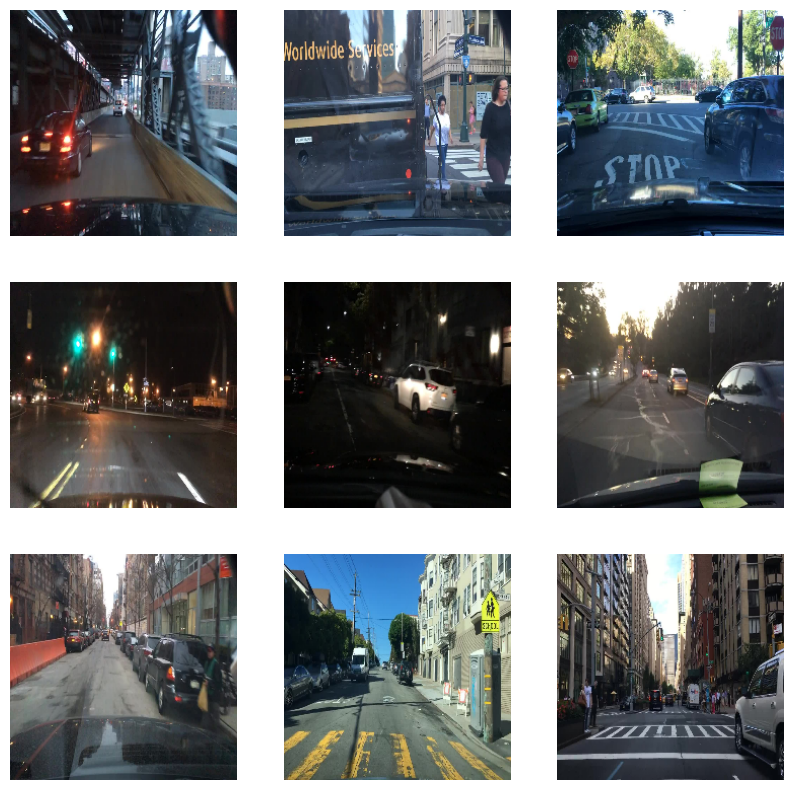

In [10]:
# Function to visualize images
def visualize_augmented_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")
    plt.show()

# Visualize augmented images
visualize_augmented_images(train_ds)

/tmp/ipykernel_111/1336047961.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(classnames,rotation = 45) #rotating 45 degree


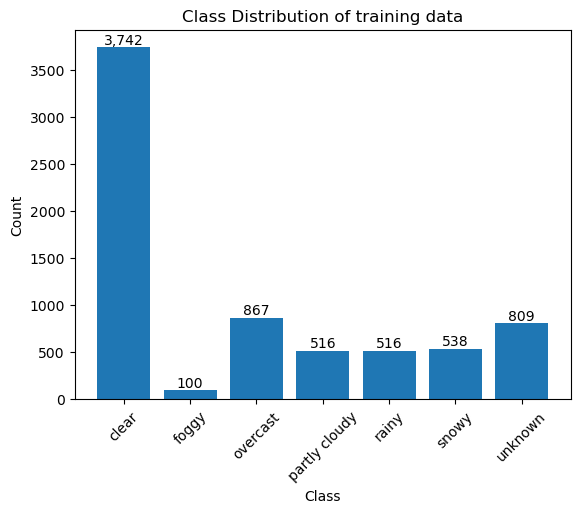

In [8]:
#Distribution of training data

# Extract labels from the dataset
labels = np.concatenate([y.numpy() for _, y in train_ds])
# print(labels)

# Calculate class distribution
unique_classes, class_counts = np.unique(labels, return_counts=True)

classnames = train_ds.class_names

# print(unique_classes)
# print(class_counts)
# print(classnames)

# Plot the distribution
fig, ax = plt.subplots()
bar_container = ax.bar(classnames, class_counts)
ax.set(xlabel = 'Class', ylabel='Count', title='Class Distribution of training data')
ax.set_xticklabels(classnames,rotation = 45) #rotating 45 degree

ax.bar_label(bar_container, fmt='{:,.0f}')
plt.show()

In [9]:
## optimiser anaugmented_train_dsraining parameters
learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 32
num_epochs = 40

## tranformer parameters
# input image size, the model will resize image to this size. Bigger images means more patches, which 
# means more fine-grained spatial relationships. Bigger images also means things get much slower
image_size = 224  # CIFAR-100 images are natively 32x32, I'm leaving that at this size
# patch size, how big is each "element" in our sequence? This should be a factor of the image size
patch_size = 16  # 8x8, we'll get 16 patches per image at a 32x32 image
# number of patches, derived from the above two parameters
num_patches = (image_size // patch_size) ** 2
# the embedding size we'll use for our patches. Each of our patches will be projected into something
# of this size. A bigger value will mean a richer representation (but slower)
projection_dim = 32
# number of attention heads
num_heads = 4
# size of the transfomer layer, note that there are two dense layers, the second of which is the same 
# size as the embedding
transformer_units = projection_dim * 2
# number of transformer layres
transformer_layers = 3
# size of the dense layers of classifier, i.e. after the transformers, prior to the final softmax layer
# for classification
mlp_head_units = [512, 256]  

#### Data Augmentation

In [10]:
# Define the data augmentation pipeline
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
        layers.RandomZoom(0.2, 0.2),
        layers.RandomContrast(0.5)
    ],
    name="data_augmentation",
)

# Apply the data augmentation to the training dataset
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

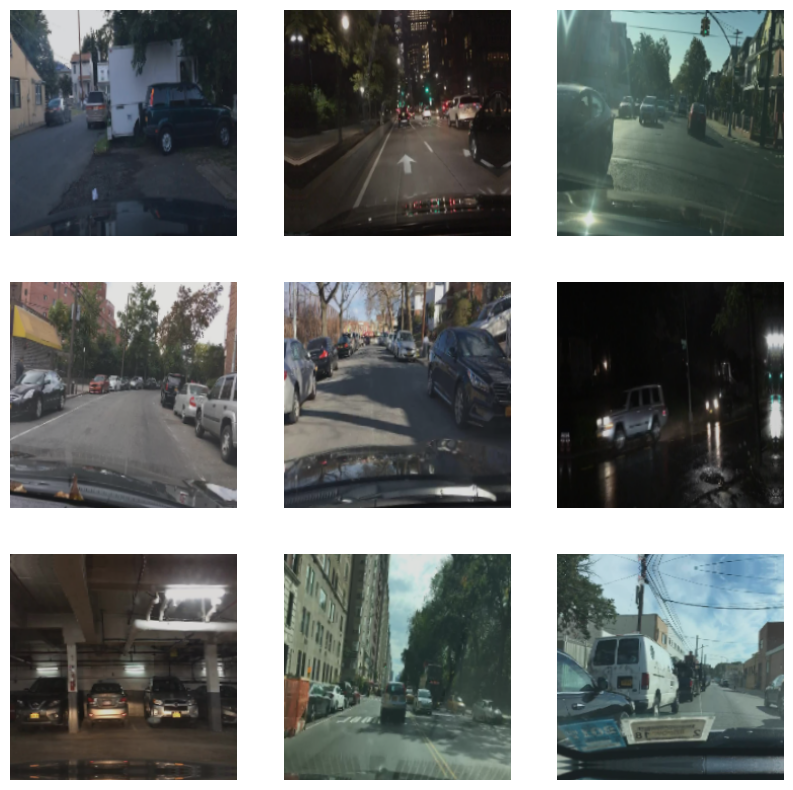

In [11]:
# Function to visualize images
def visualize_augmented_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")
    plt.show()

# Visualize augmented images
visualize_augmented_images(augmented_train_ds)

### Images as sequences

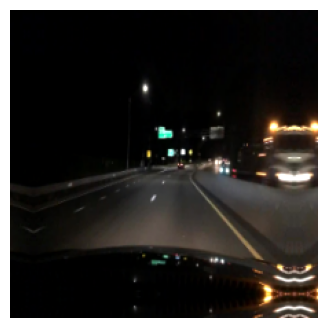

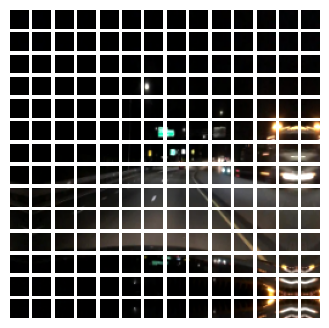

In [12]:
# Define the Patches layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Visualize an augmented image and its patches
plt.figure(figsize=(4, 4))

# Extract a batch of augmented images
for images, _ in augmented_train_ds.take(1):
    image = images[0].numpy().astype("uint8")
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(img_height, img_width))
    patches = Patches(patch_size)(resized_image)

    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(4, 4))
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i + 1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        plt.imshow(patch_img.numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

#### Network Building

In [13]:
# small function to create a simple MLP
def mlp(x, hidden_units, dropout_rate):
    # create dense layers, with a drop-out in between
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        # Project patches
        projected_patches = self.projection(patch)
        #print(f"Projected patches shape: {projected_patches.shape}")
        
        # Create positions and embed them
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        embedded_positions = self.position_embedding(positions)
        #print(f"Embedded positions shape: {embedded_positions.shape}")
        
        # Ensure shapes are compatible for addition
        batch_size = tf.shape(projected_patches)[0]
        broadcasted_positions = tf.broadcast_to(embedded_positions, [batch_size, self.num_patches, tf.shape(embedded_positions)[-1]])
        #print(f"Broadcasted positions shape: {broadcasted_positions.shape}")

        encoded = projected_patches + broadcasted_positions
        return encoded


# our transformer block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        #print(f"Attention output shape: {attn_output.shape}")  # Add this line
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        #print(f"FFN output shape: {ffn_output.shape}")  # Add this line
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [14]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        encoded_patches = TransformerBlock(projection_dim, num_heads, transformer_units)(encoded_patches)

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=logits)
    return model

vit_classifier = create_vit_classifier()
print(vit_classifier.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patches_1 (Patches)             │ (None, None, 768)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_encoder (PatchEncoder)    │ (None, 196, 32)        │        30,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 196, 32)        │        21,120 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 196, 32)        │        21,120 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 196, 32)        │        21,120 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_6           │ (None, 196, 32)        │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,439,207 (13.12 MB)

 Trainable params: 3,439,207 (13.12 MB)

 Non-trainable params: 0 (0.00 B)

None


In [16]:
# Inverse of class frequencies
# Define the class frequencies
class_frequencies = [3742, 100, 867, 516, 516, 518, 809]

# Calculate total number of samples
total_samples = sum(class_frequencies)

# Calculate class weights
class_weights = {}
for i, freq in enumerate(class_frequencies):
    class_weights[i] = total_samples / (len(class_frequencies) * freq)

print("Class Weights:", class_weights)

Class Weights: {0: 0.26983278613422923, 1: 10.097142857142858, 2: 1.1646070192782996, 3: 1.956810631229236, 4: 1.956810631229236, 5: 1.9492553778268065, 6: 1.2481017128730354}


In [15]:
def run_experiment(model):
    #Define the optimizer
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    # optimizer = keras.optimizers.Adam(learning_rate=learning_rate)


    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.sparse_categorical_crossentropy],
        #     keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        #     keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        # ],
        jit_compile=False
    )

    # Checkpoint callback to save the best model
    checkpoint_file = "vit.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_file,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    # Print shapes of augmented images, patches, and encoded patches
    for images, labels in augmented_train_ds.take(1):
        augmented_images = data_augmentation(images, training=True)
        patches = Patches(patch_size)(augmented_images)
        encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
        #print("Augmented images shape:", augmented_images.shape)
        #print("Patches shape:", patches.shape)
        #print("Encoded patches shape:", encoded_patches.shape)

    # Fit the model
    history = model.fit(
        augmented_train_ds,  # Use the augmented training dataset
        validation_data=val_ds,  # Ensure you have a validation dataset defined
        epochs=num_epochs,
        callbacks=[checkpoint_callback],
        verbose=1
        #class_weight = class_weights
    )

    # Load the best model weights
    #model.load_weights(checkpoint_file)

    return history, model


def eval_model(history, model):
    # Get predictions on the training and test datasets
    train_predictions = model.predict(augmented_train_ds)
    test_predictions = model.predict(test_ds)
    train_samples = len(augmented_train_ds)
    test_samples = len(test_ds)

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["accuracy"], label="Top-1 Accuracy (Training)")
    plt.plot(history.history["top-5-accuracy"], label="Top-5 Accuracy (Training)")
    plt.plot(history.history["val_accuracy"], label="Top-1 Accuracy (Validation)")
    plt.plot(history.history["val_top-5-accuracy"], label="Top-5 Accuracy (Validation)")
    plt.xlabel('Epoch')
    plt.ylabel('% Accuracy')
    plt.legend()
    plt.show()
    
    # Calculate Cumulative Match Characteristic (CMC)
    cmc_train = []
    cmc_test = []
    rank = []
    for i in range(1, 101):
        cmc_train.append(100.0 * np.sum(tf.math.in_top_k(y_train[:, 0], train_predictions, i)) / train_samples)
        cmc_test.append(100.0 * np.sum(tf.math.in_top_k(y_test[:, 0], test_predictions, i)) / test_samples)
        rank.append(i)

    # Plot CMC
    plt.figure(figsize=(10, 6))
    plt.plot(rank, cmc_train, label="Training Data")
    plt.plot(rank, cmc_test, label="Testing Data")
    plt.grid()
    plt.legend()
    plt.xlabel('Rank')
    plt.ylabel('% Accuracy')
    plt.show()



In [16]:
train_time = process_time()
history, model = run_experiment(vit_classifier)
train_time_end = process_time()

Epoch 1/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 43s 166ms/step - loss: 2.2266 - sparse_categorical_crossentropy: 5.3731 - val_loss: 1.4560 - val_sparse_categorical_crossentropy: 2.3642
Epoch 2/40


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


222/222 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - loss: 1.5454 - sparse_categorical_crossentropy: 4.6123 - val_loss: 1.3536 - val_sparse_categorical_crossentropy: 2.3844
Epoch 3/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - loss: 1.4798 - sparse_categorical_crossentropy: 4.1650 - val_loss: 1.3334 - val_sparse_categorical_crossentropy: 2.6829
Epoch 4/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - loss: 1.4335 - sparse_categorical_crossentropy: 4.1217 - val_loss: 1.3154 - val_sparse_categorical_crossentropy: 2.9021
Epoch 5/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 37s 164ms/step - loss: 1.4041 - sparse_categorical_crossentropy: 3.6369 - val_loss: 1.2923 - val_sparse_categorical_crossentropy: 2.7243
Epoch 6/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 37s 167ms/step - loss: 1.3759 - sparse_categorical_crossentropy: 3.4643 - val_loss: 1.2447 - val_sparse_categorical_crossentropy: 2.7519
Epoch 7/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - loss: 1.3474 - sparse_categorical_crossentropy: 3.3229 - val_loss: 1.

In [19]:
training_time = train_time_end - train_time
print("Training time:", training_time)

Training time: 2595.724926825


KeyError: 'accuracy'

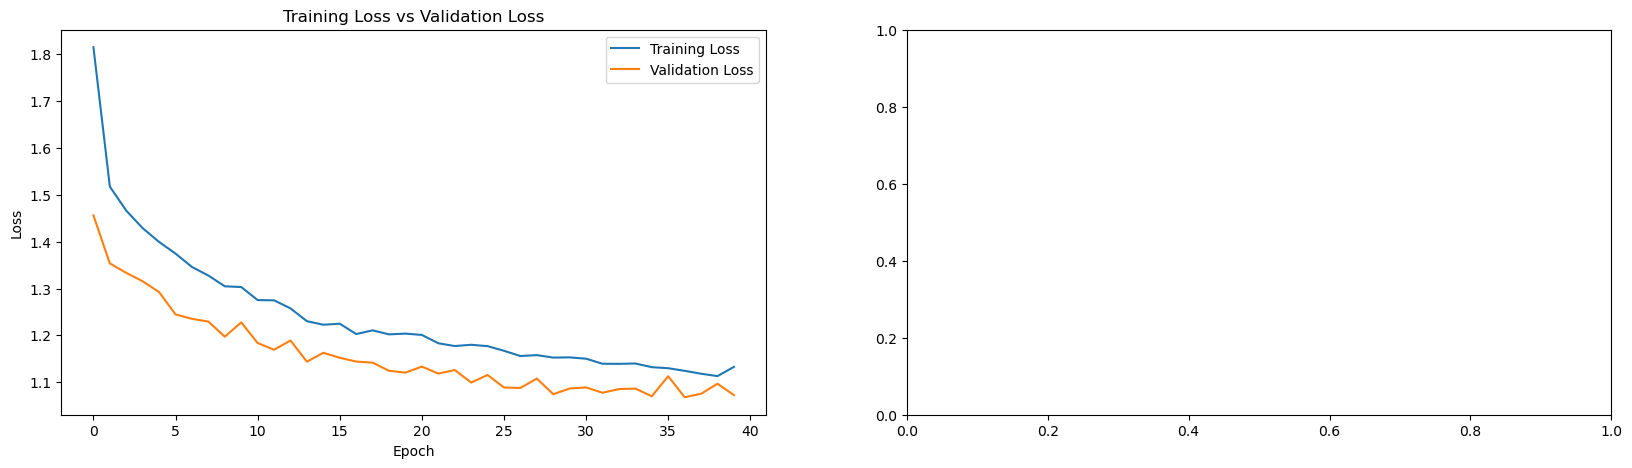

In [23]:
def plot_training(history):
    fig = plt.figure(figsize=[20, 5])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss vs Validation Loss')
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'], label="Train Accuracy")
    ax.plot(history.history['val_accuracy'], label="Val Accuracy")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training Accuracy vs Validation Accuracy')
    ax.legend()

    plt.show()
    
plot_training(history)

In [21]:
y_train = np.concatenate([y for x,y in train_ds.as_numpy_iterator()])
y_test = np.concatenate([y for x,y in test_ds.as_numpy_iterator()])

#print(y_class_test.shape)
pred_time_train = process_time()
train_pred = model.predict(train_ds)
pred_time_end = process_time()

pred_end_train = pred_time_end - pred_time_train

pred_time_test = process_time()
test_pred = model.predict(test_ds)
pred_end_test = process_time()

pred_end_test = pred_end_test - pred_time_test

print("Train time:", pred_end_train)
print("Test time:", pred_end_test)

#print(test_pred)

222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Train time: 23.296447862999685
Test time: 4.894496979999985


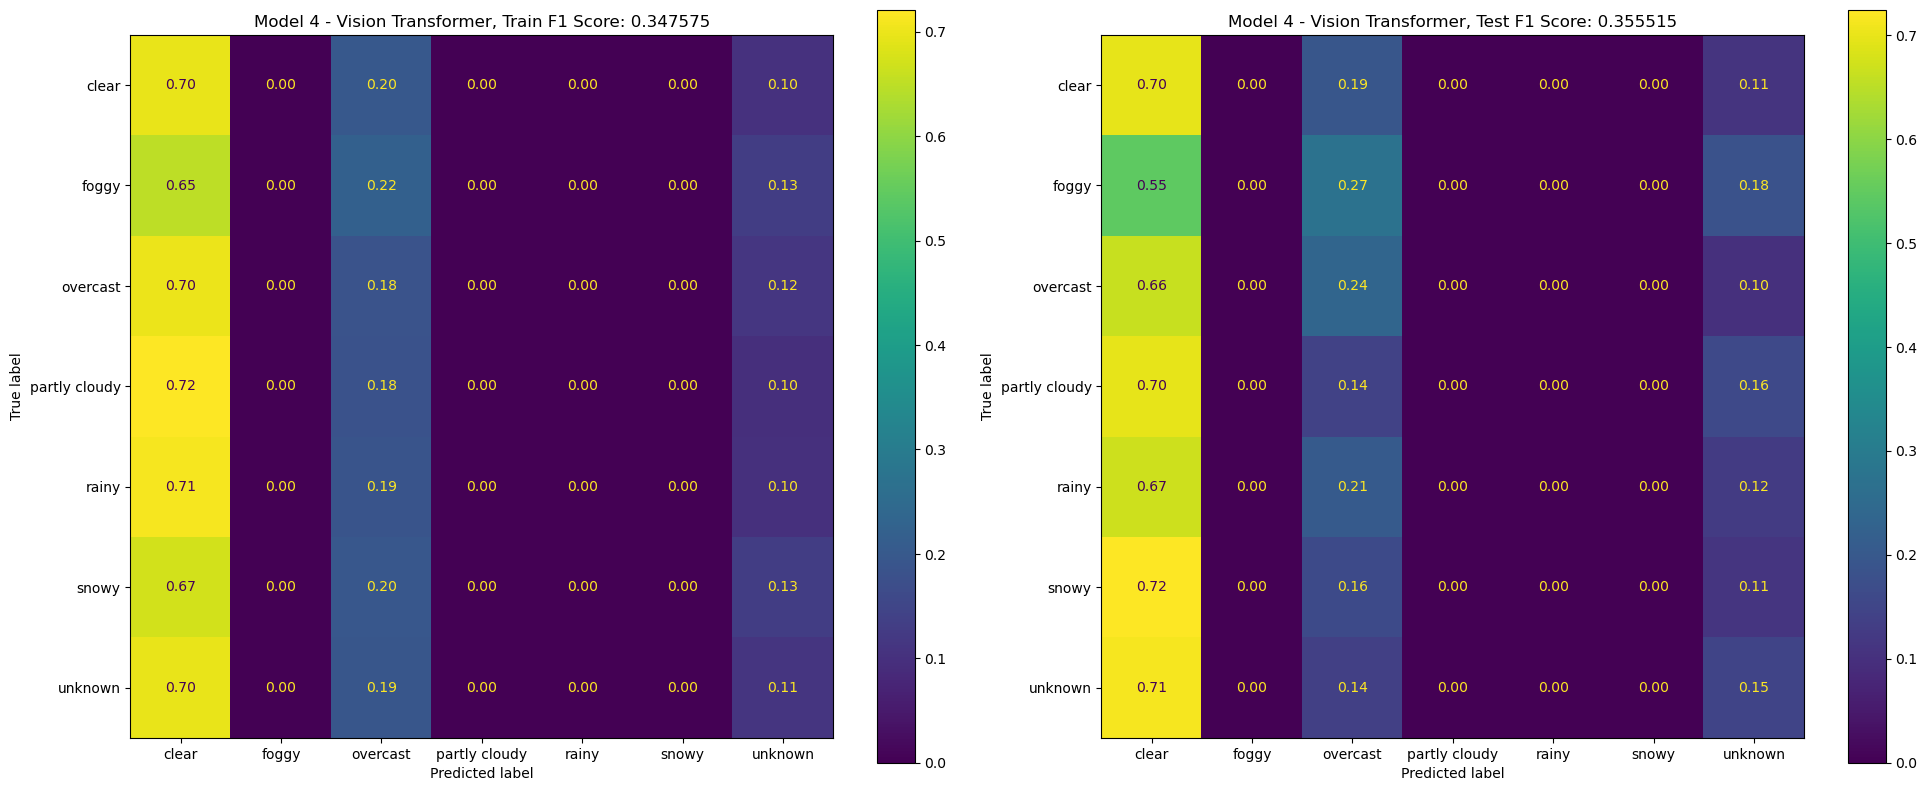

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
import tensorflow as tf

# Define class names
class_names = ['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown']

# Convert predictions to class labels
train_pred_labels = np.argmax(train_pred, axis=1)
test_pred_labels = np.argmax(test_pred, axis=1)

# Compute confusion matrices
train_confusion_mtx = confusion_matrix(y_train, train_pred_labels, normalize='true')
test_confusion_mtx = confusion_matrix(y_test, test_pred_labels, normalize='true')

# Create a single figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=[20, 8])

# Plot the confusion matrix for the training set
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_confusion_mtx, display_labels=class_names)
disp_train.plot(ax=axes[0], values_format='.2f')
train_f1 = f1_score(y_train, train_pred_labels, average='weighted')
axes[0].set_title('Model 4 - Vision Transformer, Train F1 Score: %f' % train_f1)

# Plot the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_confusion_mtx, display_labels=class_names)
disp_test.plot(ax=axes[1], values_format='.2f')
test_f1 = f1_score(y_test, test_pred_labels, average='weighted')
axes[1].set_title('Model 4 - Vision Transformer, Test F1 Score: %f' % test_f1)

# Display the plot
plt.tight_layout()
plt.show()

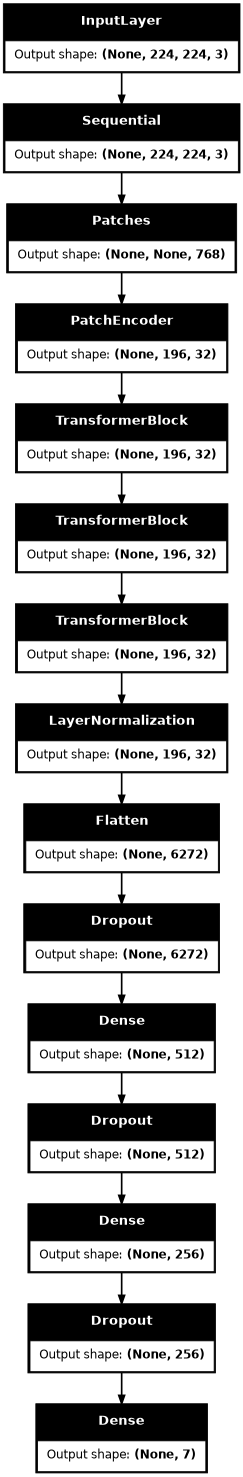

In [153]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, dpi=60)